# Galaxies: An interactive graduate course

## Chapter 2.1: SDSS: Distribution in real and redshift space

#### (c) Benedikt Diemer, University of Maryland (based on similar notebooks by Andrey Kravtsov, University of Chicago)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### Downloading data from the SDSS server

In the following, we will use data from the [Sloan Digital Sky Survey](https://www.sdss.org/) (SDSS) to explore the observed population of galaxies. You do NOT need to execute the following steps to run the rest of this notebook because I provide a FITS file with the data, but it might be good to know how to do it in general. The steps are as follows:

* Create an account on [SciServer](https://apps.sciserver.org/)
* Log into [CasJobs](https://skyserver.sdss.org/CasJobs/default.aspx), the SDSS database interface
* Under "Query" you can submit an SQL query; see below for the query that creates our dataset. Here, we select a number of fields from galaxies and their corresponding "spectroscopic objects" (see query below). Select "DR8" as Context and set MyTable to sdss_specgal_dr8. You can also choose a name for your query under which it will appear in the queue. While there are many data releases after DR8, those contain data that are not relevant to our purpose in this case.
* Once you submit the query, it will appear in your History and show whether it has started, finished, or crashed. 
* Once the query has successfully completed, the output is written into a ``sdss_specgal_dr8`` table in our personal database, ``mydb``. 
* Find it under the "MyDB" tab, click on it, and click "Download" from the buttons on the right. Select "FITS Binary" from the dropdown menu of file types and click "Go" to create the file.
* Once the file has been created, you can download it from the "Output" tab.

The SQL query to select our spectroscopic galaxy sample is as follows:

This might look like gibberish at first sight, but it basically means:
* ``SELECT``: choose the following properties
* ``INTO``: store in a table in our local database
* ``FROM``: define the objects from which we take the data. We start from a spectroscopic object type (or ``SpecObj``) that we call ``S`` for brevity. We then ``CROSS APPLY`` (cross-match) this type of object (which is really a table with object properties) with a number of other objects (tables) such as ``Galaxy`` and certain tables of galaxy spectroscopic data. The tables are documented [here](https://skyserver.sdss.org/dr8/en/help/browser/browser.asp). Many of the quantities we want are in the [Galaxy table](https://skyserver.sdss.org/dr8/en/help/browser/browser.asp). Note that there are the underlying tables but also so-called "views" that provide a different way to organize the data (``Galaxy`` is a view, for example). ``fGetNearestObjEQ`` is a function that returns the nearest object to a certain coordinate.
* ``WHERE``: choose which objects to add to our dataset by first cross-matching the IDs and then imposing some magnitude and redshift cuts.

Some of the algorithms that create the tables are discussed on the [DR8 Documentation](https://www.sdss3.org/dr8/whatsnew.php) page on [algorithms](https://www.sdss3.org/dr8/algorithms/).

### Loading the SDSS data file

The downloaded SDSS data are in a FITS file, a format that is exclusively used by (observational) astronomers. To avoid coding the same lines over and over again, we encapsulate the loading process in a small function that can be found in [obs_sdss.py](routines/obs_sdss.py). We exclude very small redshifts since they can cause all kinds of numerical errors.

In [2]:
from routines import obs_sdss

# Load SDSS file and print its fields. Note that the returned format is similar, 
# but not equivalent, to a "structure array" in numpy.
data = obs_sdss.loadSdssSpecSample()

print('Found %d galaxies with the following fields:' % (len(data)))
for i in range(len(data.columns.names)):
    print(data.columns.names[i])

Found 673232 galaxies with the following fields:
ra
dec
mjd
plate
fiberID
class
z
zErr
rChi2
velDisp
velDispErr
extinction_u
extinction_g
extinction_r
extinction_i
extinction_z
fiberMag_u
fiberMag_g
fiberMag_r
fiberMag_i
fiberMag_z
modelMag_u
modelMag_g
modelMag_r
modelMag_i
modelMag_z
cmodelMag_u
cmodelMag_g
cmodelMag_r
cmodelMag_i
cmodelMag_z
phioffset_r
fracdeV_r
deVRad_r
deVRadErr_r
deVAB_r
deVABErr_r
deVPhi_r
lnLDeV_r
deVMag_r
deVMagErr_r
expRad_r
expRadErr_r
expAB_r
expABErr_r
expPhi_r
lnLExp_r
expMag_r
expMagErr_r
petroMag_u
petroMag_g
petroMag_r
petroMag_i
petroMag_z
petroRad_u
petroRad_g
petroRad_r
petroRad_i
petroRad_z
petroR50_r
petroR90_r
petroR50Err_r
petroR90Err_r
h_alpha_flux
h_alpha_flux_err
oiii_5007_flux
oiii_5007_flux_err
d4000
d4000_err
bptclass
lgm_tot_p50
sfr_tot_p50
objID
specObjID


Lots of fields! In the following notebooks, we will become familiar with a number of additional quantities that we need time and time again. To avoid code repetition, we thus add another loading function that returns a structured array (see [numpy docs](https://numpy.org/doc/stable/user/basics.rec.html)) with the original and additional quantities. The code doesn't make sense at this point yet, but you can find it in ``obs_sdss.py``.

In [3]:
data = obs_sdss.loadSdssSpecSampleExtra()

print('Found %d galaxies with the following fields:' % (len(data)))
for k in data.dtype.names:
    print(k)

Found 672813 galaxies with the following fields:
ra
dec
mjd
plate
fiberID
class
z
zErr
rChi2
velDisp
velDispErr
extinction_u
extinction_g
extinction_r
extinction_i
extinction_z
fiberMag_u
fiberMag_g
fiberMag_r
fiberMag_i
fiberMag_z
modelMag_u
modelMag_g
modelMag_r
modelMag_i
modelMag_z
cmodelMag_u
cmodelMag_g
cmodelMag_r
cmodelMag_i
cmodelMag_z
phioffset_r
fracdeV_r
deVRad_r
deVRadErr_r
deVAB_r
deVABErr_r
deVPhi_r
lnLDeV_r
deVMag_r
deVMagErr_r
expRad_r
expRadErr_r
expAB_r
expABErr_r
expPhi_r
lnLExp_r
expMag_r
expMagErr_r
petroMag_u
petroMag_g
petroMag_r
petroMag_i
petroMag_z
petroRad_u
petroRad_g
petroRad_r
petroRad_i
petroRad_z
petroR50_r
petroR90_r
petroR50Err_r
petroR90Err_r
h_alpha_flux
h_alpha_flux_err
oiii_5007_flux
oiii_5007_flux_err
d4000
d4000_err
bptclass
lgm_tot_p50
sfr_tot_p50
objID
specObjID
K_u
K_g
K_r
K_i
K_z
color_ug
color_gr
color_ri
color_iz
DM
dL
dA
M_model_u
m_model_u
M_cmodel_u
m_cmodel_u
M_petro_u
m_petro_u
M_fiber_u
m_fiber_u
M_model_g
m_model_g
M_cmodel_g
m_cmod

### Footprint of galaxies on the sky

Let's plot the distribution of SDSS galaxies on the sky, i.e., their right ascension and declination. Those numbers are given in degrees:

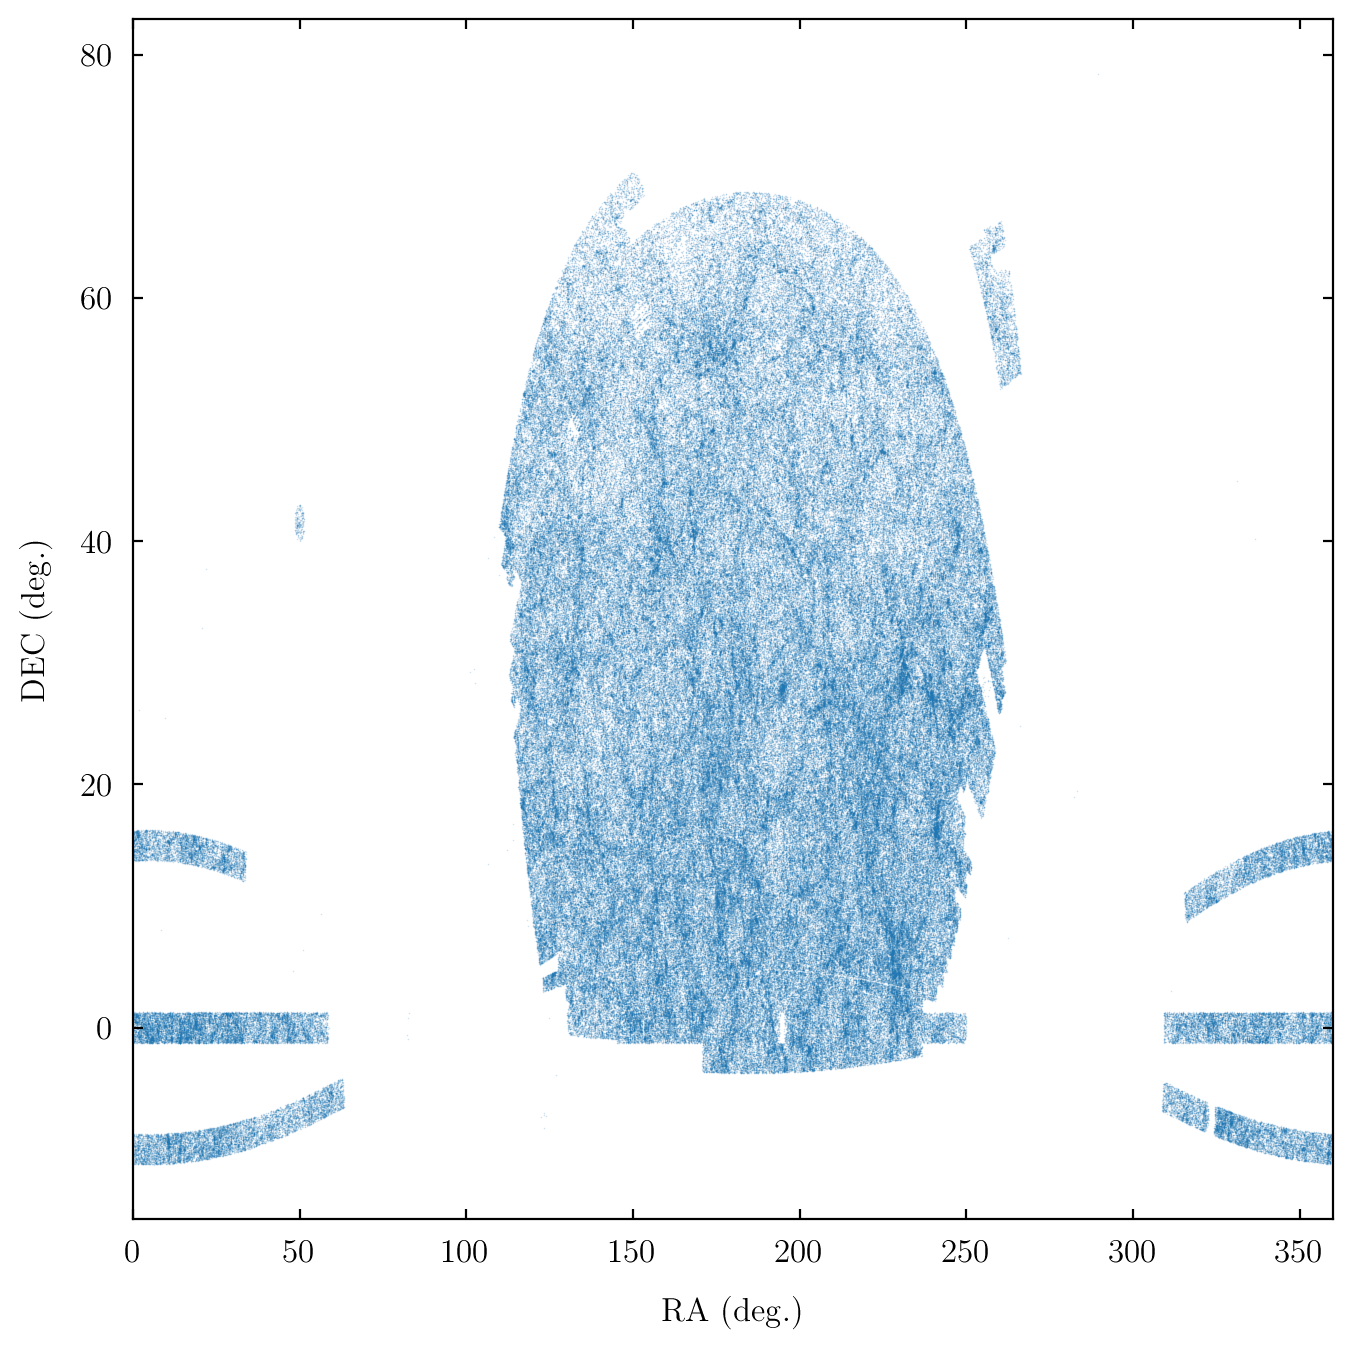

In [4]:
fig = plt.figure(figsize = (8.0, 8.0))
plt.xlim(0.0, 360.0)
plt.xlabel(r'$\mathrm{RA\ (deg.)}$')
plt.ylabel(r'$\mathrm{DEC\ (deg.)}$')
plt.scatter(data['ra'], data['dec'], marker = '.', s = 1.2, linewidths = 0, alpha = 0.2)
plt.show()

We can clearly see a filimentary large-scale structure in the distribution, but the plot looks a little weird because of the projection. Let's instead use a Hammer projection (other projections such as Mollweide give very similar results):

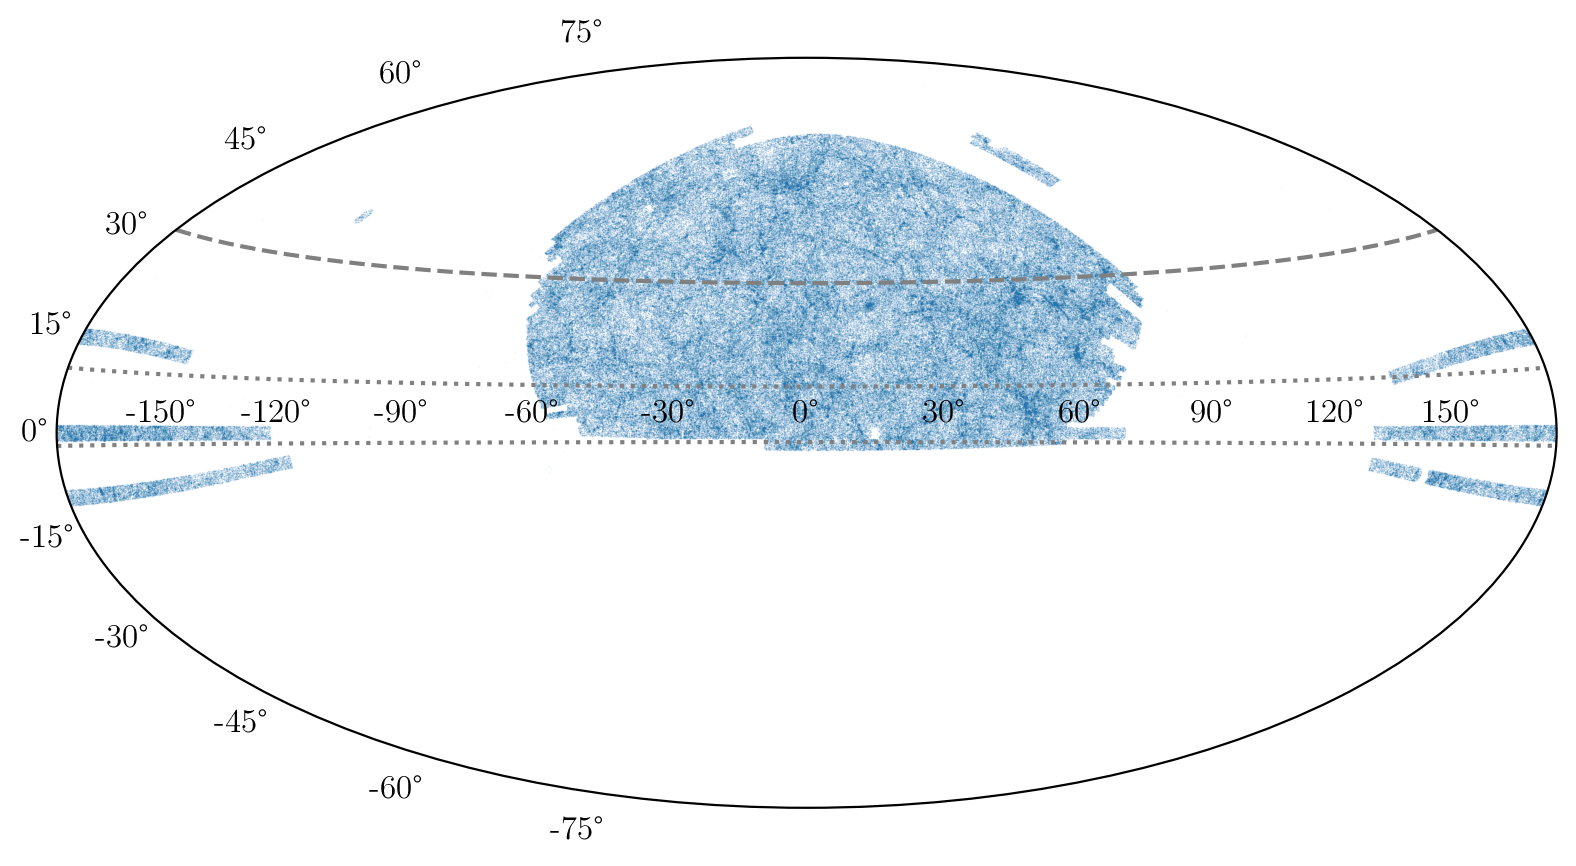

In [5]:
ra_rad = data['ra'] * np.pi / 180.0
dec_rad = data['dec'] * np.pi / 180.0

apache_point_dec = 32.78
dec_slice_min = -2.0
dec_slice_max = 10.0
ra_array = np.linspace(-np.pi, np.pi, 100)
ones_array = np.ones((100), float)

fig = plt.figure(figsize = (10.0, 10.0))
ax = fig.add_subplot(111, projection = 'hammer')
plt.scatter(ra_rad - np.pi, dec_rad, marker = '.', s = 1.0, linewidths = 0, alpha = 0.1)
plt.plot(ra_array, ones_array * apache_point_dec * np.pi / 180.0, '--', color = 'gray')
plt.plot(ra_array, ones_array * dec_slice_min * np.pi / 180.0, ':', color = 'gray')
plt.plot(ra_array, ones_array * dec_slice_max * np.pi / 180.0, ':', color = 'gray')
plt.show()

The area covered by SDSS emerges very clearly. The dashed lines shows the declination of the Apache Point Observatory. The dotted lines show a slice that we will use for another plot below.

### Distribution in redshift

Let's plot a histogram of the redshifts of our spectroscopic galaxy sample. It's instructive to plot this both on a logarithmic scale (to highlight the highest redshifts) and on a linear scale (to get a sense of where the majority of the galaxies are):

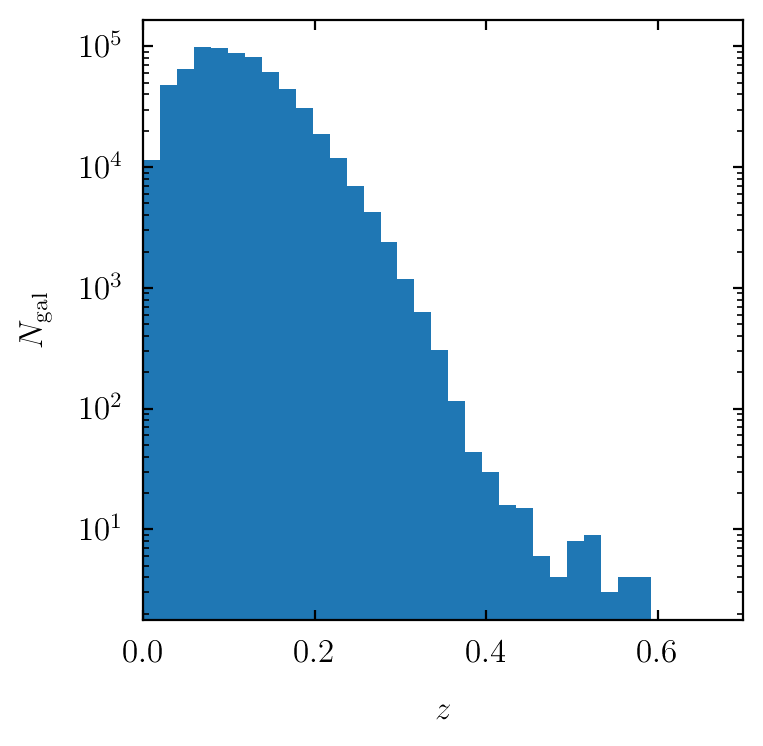

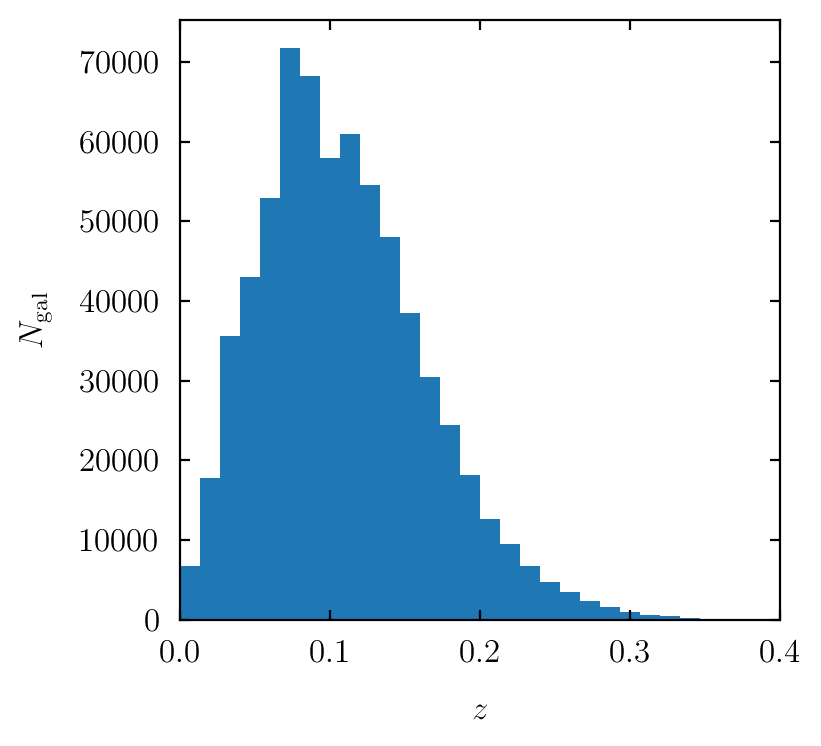

In [6]:
plt.figure(figsize = (4.0, 4.0))
plt.xlim(0.0, 0.7)
plt.xlabel(r'$z$')
plt.ylabel(r'$N_{\rm gal}$')
plt.hist(data['z'], bins = 30, log = True)
plt.show();

plt.figure(figsize = (4.0, 4.0))
plt.xlim(0.0, 0.4)
plt.xlabel(r'$z$')
plt.ylabel(r'$N_{\rm gal}$')
plt.hist(data['z'], bins = 30, log = False, range = [0, 0.4])
plt.show();

The conclusion is that our SDSS sample basically covers a redshift range from $0 < z < 0.3$ or so, with a few galaxies at higher redshifts.

### Distribution in "3D" space

The redshift distributions above correspond to a large range of physical distances to galaxies. Thus, our plots of large-scale structure above are projecting through a large line-of-sight distance. To get a sense of the distribution in the distance (redshift) direction, we can also plot a "top-down" view of wedges of galaxies in a narrow slice of DEC.

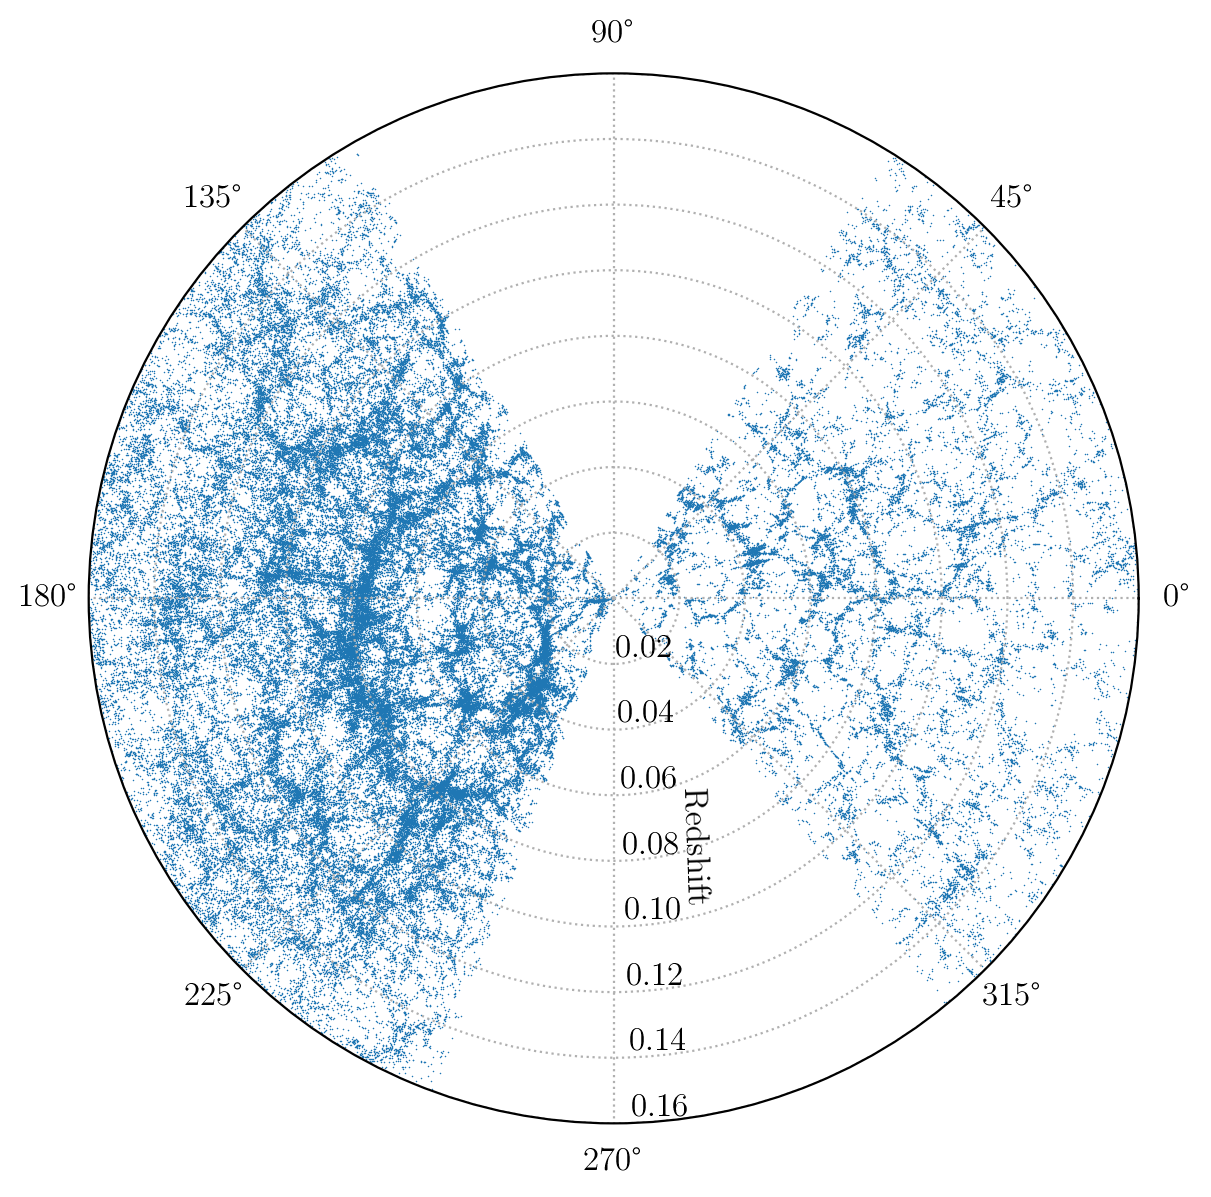

In [7]:
z_max = 0.16

mask = (data['z'] <= z_max) & (data['dec'] >= dec_slice_min) & (data['dec'] <= dec_slice_max)
ra_rad = data['ra'][mask] * np.pi / 180.0
z = data['z'][mask]

fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(111, projection = 'polar')
ax.set_rlabel_position(-88.0)
ax.scatter(ra_rad, z, marker = '.', s = 1.2, linewidths = 0, rasterized = True)
ax.set_rmax(z_max)
ax.grid(ls = ':')
label_position = ax.get_rlabel_position()
ax.text(np.radians(label_position + 16), ax.get_rmax() * 0.5, r'$\mathrm{Redshift}$', rotation = label_position, ha = 'center', va = 'center')
plt.show()

One feature that is immediately apparent on the left is the "Sloan Great Wall," basically a massive filament. We can take a closer look, selecting the relevant range of RA/DEC/z and rotating it into a more convenient view:

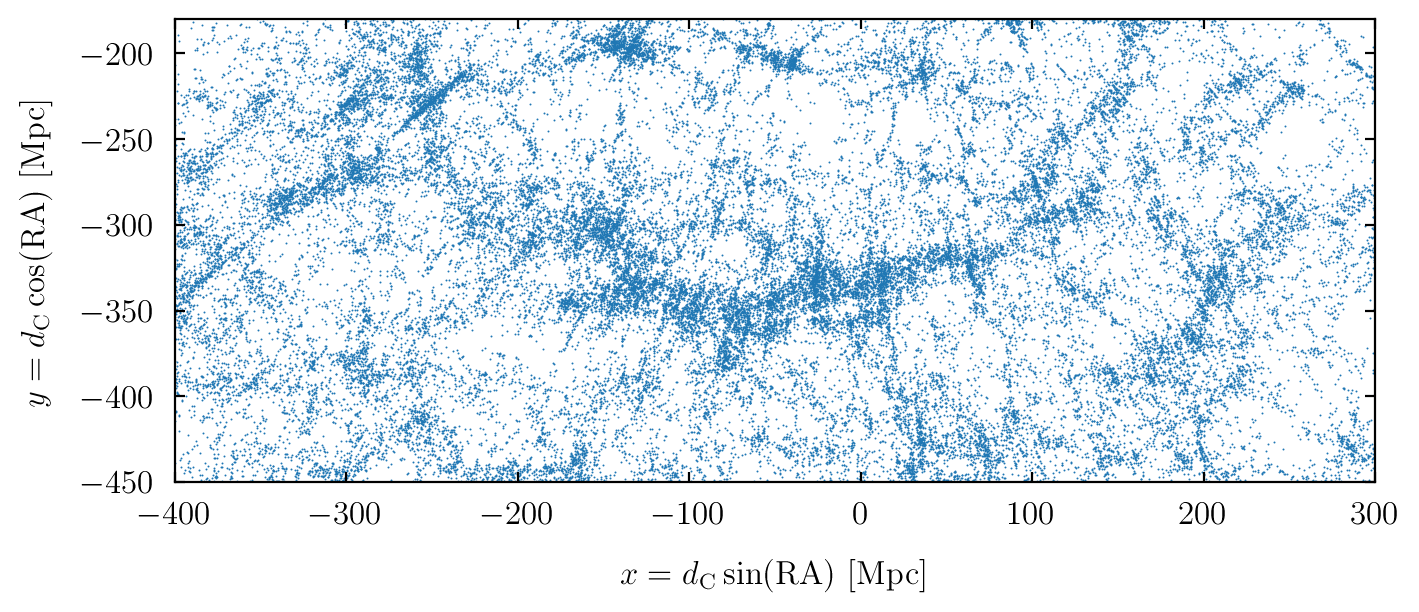

In [8]:
from colossus.cosmology import cosmology

mask = ((data['dec'] > -7) & (data['dec'] < 7) & (data['ra'] > 80) & (data['ra'] < 280) & (data['z'] < 0.14))
cosmo = cosmology.getCurrent()
d_com = cosmo.comovingDistance(0.0, data['z'][mask]) / cosmo.h
ra_rad = data['ra'][mask] * np.pi / 180.0
dec_rad = data['dec'][mask] * np.pi / 180.0
x = d_com * np.sin(ra_rad) * np.cos(dec_rad)
y = d_com * np.cos(ra_rad) * np.cos(dec_rad)

fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(111, aspect = 'equal')
ax.scatter(x, y, marker = '.', s = 2.0, linewidths = 0)
ax.set_xlim(-400, 300)
ax.set_ylim(-450, -180)
ax.set_xlabel(r'$x = d_{\rm C} \sin({\rm RA})\ [\rm Mpc]$')
ax.set_ylabel(r'$y = d_{\rm C} \cos({\rm RA})\ [\rm Mpc]$')
plt.show()

We notice streaks in the redshift direction, the so-called "fingers of god." This effect is caused by the velocity dispersion within halos, which adds line-of-sight peculiar velocities to galaxies orbiting in that halo. These peculiar alter the measured total velocity, which we assume to be the Hubble velocity, and thus distort the distance we infer. 

### What do SDSS galaxies look like?

Let's plot a collage of SDSS images of randomly selected galaxies. The [obs_sdss.py](routines/obs_sdss.py) code file contains general functions to download images from the SDSS image server and plot them as a collage:

The images are downloaded from a webserver as they are needed:

The scale is in units of arseconds/pixel. The natural scale of the SDSS camera is 0.396127 arcsec/pixel. If we lowered the scale, we would "zoom into" the images a little (i.e., the resolution of the underlying images would be lower than the images we are plotting). If we increased the scale, we would be down-sampling the images.

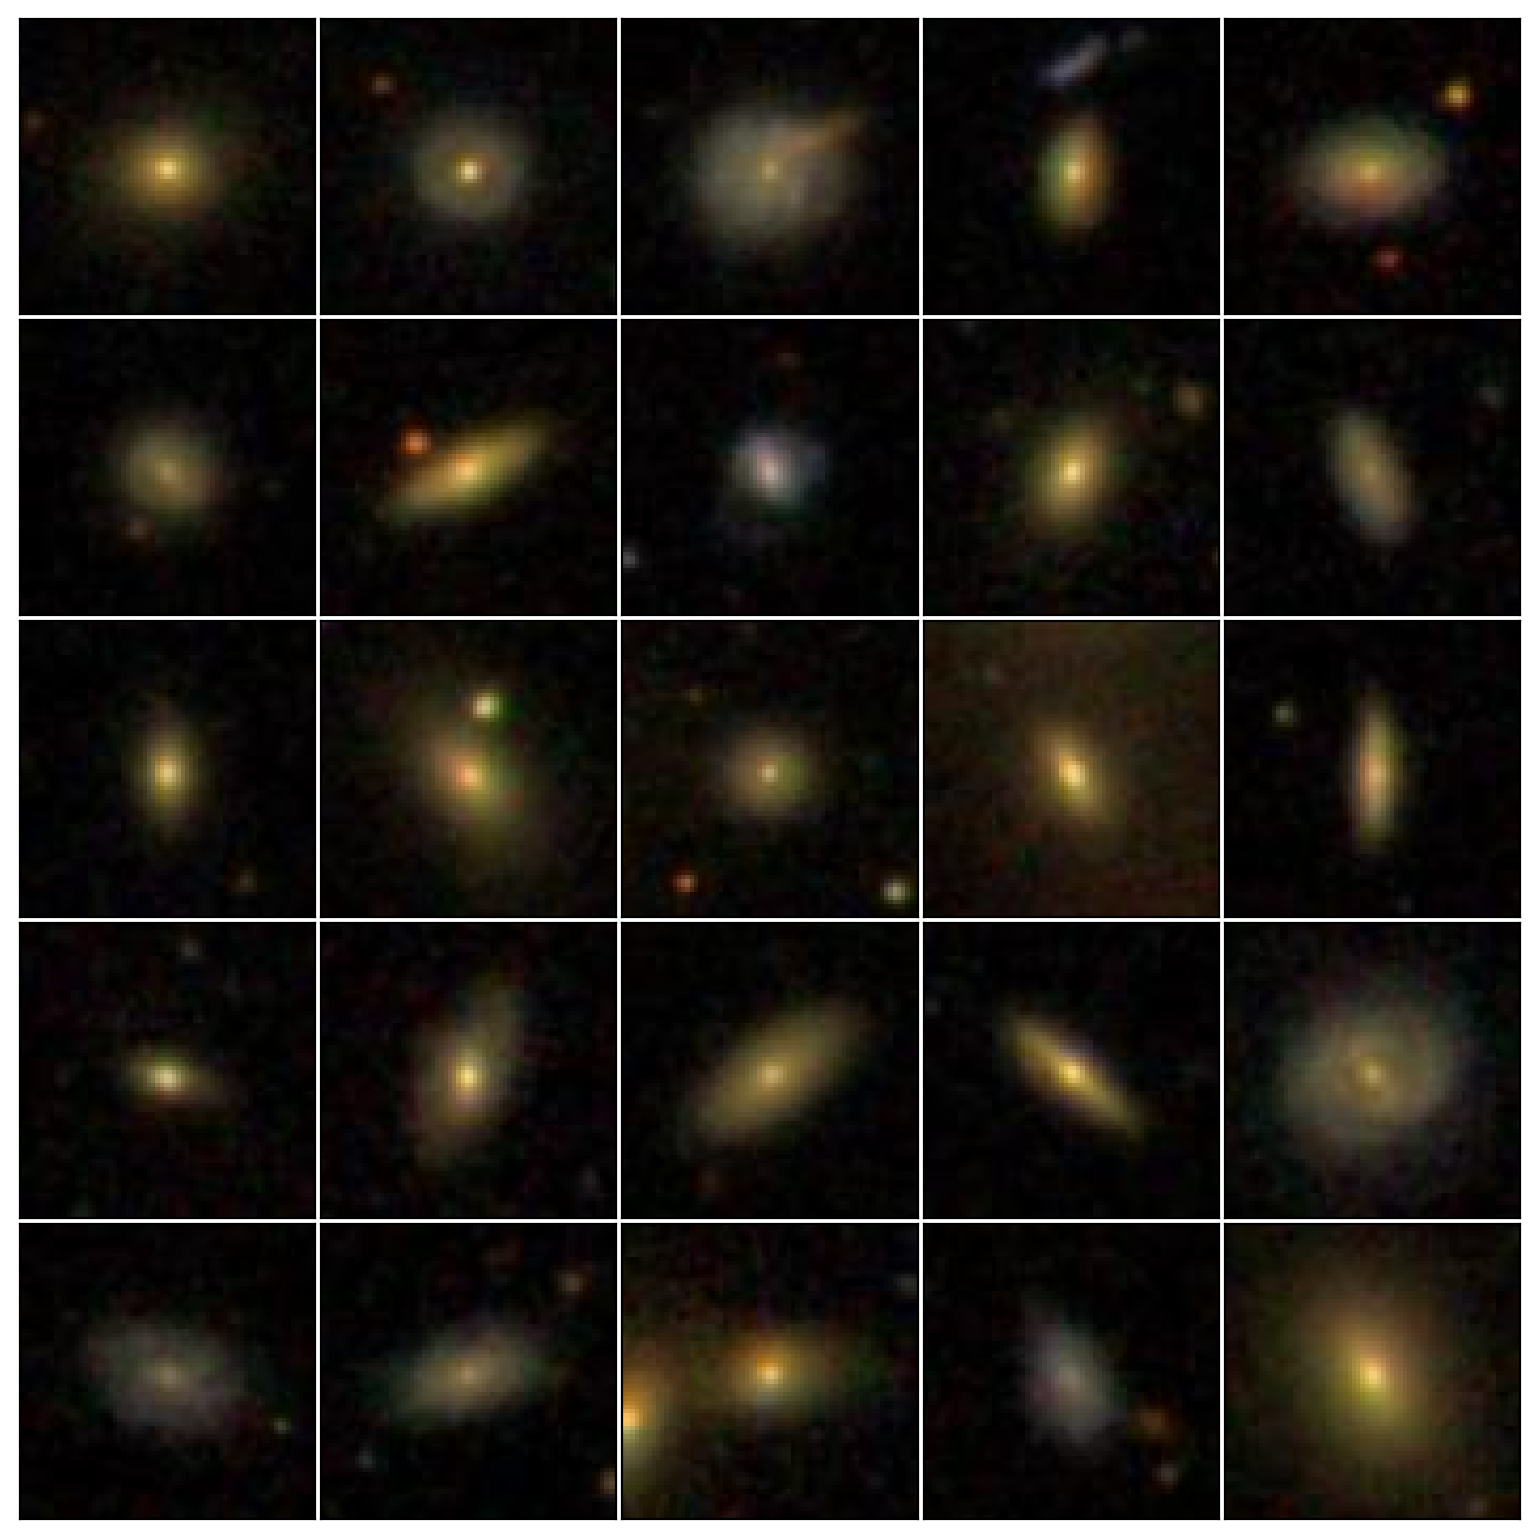

In [9]:
n_rows = 5
n_cols = 5
n_pix = 70
scale = obs_sdss.sdss_pixel_scale
np.random.seed(2025)

# Compute the luminosity distance and select galaxies in a particular, fairly nearby,
# range. Then select random indices.
dL = cosmo.luminosityDistance(data['z'])
idxs_valid = np.where((dL >= 200.0) & (dL <= 300.0))[0]
n_valid = len(idxs_valid)
idxs = idxs_valid[np.random.randint(0, n_valid - 1, n_rows * n_cols)]
d = data[idxs]

obs_sdss.imageCollage(d, n_rows, n_cols, n_pix = n_pix, scale = scale, panel_size = 2.0);

Even from these relatively poorly resolved images, we can see an assortment of disky and elliptical galaxies, as well as noticably different colors and sizes.